In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
from random import shuffle
import os
import glob
# Image processing
from PIL import Image

# We use matplotlib for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
WORK_DIR = os.path.curdir
GTSRB_DIR = WORK_DIR + '/GTSRB/'
LOG_DIR = WORK_DIR + '/cnn_output'
TRAINING_STEPS = 5000
# The number of training features we are going to train in parallel
# (to speed things up)
BATCH_SIZE = 10
# How often do we want to do screen / file log output
PRINT_STEPS = TRAINING_STEPS / 100

LEARNING_RATE = 1e-1
# Momentum smoothes out sudden changes in the gradient
MOMENTUM = 0.1
# The input image resolution (all input samples will be interpolated to this resolution)
IMAGE_RES = [48,48]
# Shall we first convert ppm files to jpg?
CONVERT_PPM = False
# Every how many training steps do we want to measure the error on the validation data
VALIDATE_EVERY = 1000

In [23]:
params={'log_dir':LOG_DIR, 
       'learning_rate': LEARNING_RATE,
       'momentum': MOMENTUM,
       'base_channels':8,
       'weight_decay':1e-5,
       'print_steps':PRINT_STEPS, 
       'save_summary_steps': PRINT_STEPS,
       'save_checkpoint_steps':VALIDATE_EVERY, 
       'validate_every': VALIDATE_EVERY, 
       'train_steps': TRAINING_STEPS}

# Preparing the datase

German Traffic Sign Recognition Benchmark (GTSRB) dataset is used from http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip.
images are in ppm format, should be transformed to jpg first.

In [5]:
def convert_from_ppm_to_jpg(directory):
    files = sorted(glob.glob(directory+'/*/*.ppm'))
    
    for filename in files:
        image=Image.open(filename)
        image.save(filename[:-4]+'.jpg')

In [6]:
CONVERT_PPM=True
if CONVERT_PPM is True:
    convert_from_ppm_to_jpg(GTSRB_DIR)

# show some images from the dataset

In [9]:
num_images=8
assert num_images%4 == 0

files = sorted(glob.glob(GTSRB_DIR+'/*/*.jpg'))
shuffle(files)
files = files[:num_images]
labels = [filename.split(os.sep)[-2] for filename in files]

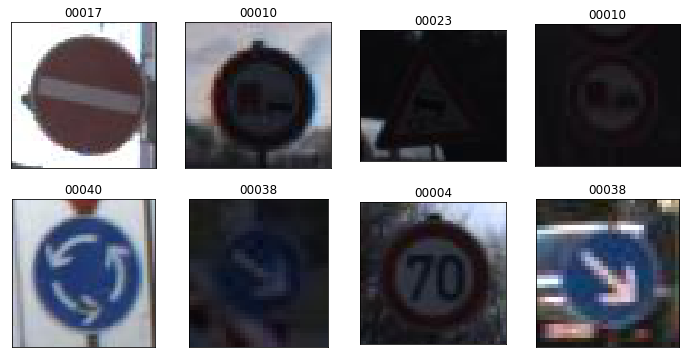

In [10]:
fig,axs = plt.subplots((num_images//4), 4, figsize=(12,6))
axs=axs.ravel()
count = 0
for file, label in zip(files, labels):
    image = mpimg.imread(file)
    axs[count].set_title(label)
    axs[count].imshow(image)
    axs[count].set_xticks([])
    axs[count].set_yticks([])
    
    count+=1

In [11]:
axs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000263ECE607F0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000263EDAD0128>], dtype=object)

# set Image and label retrieval helper functions

In [12]:
# split data set into train and test
def get_sample_filenames(directory, train_fraction=0.8):
    files = glob.glob(directory+'/*/*.jpg')
    shuffle(files)
    num_train = int(len(files)*train_fraction)
    train_set = files[:num_train]
    test_set = files[num_train:]
    
    return train_set, test_set


def get_labels(filenames):
    return [np.int32(filename.split(os.sep)[-2]) for filename in filenames]

# take filename and resolution and return the image and label
def load_sample(filename, target_res):
    image_data = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_data, channels=3)
    image_decoded = tf.image.resize_images(image_decoded, target_res, method=tf.image.ResizeMethod.BILINEAR)
    
    image_decoded = tf.cast(image_decoded,tf.uint8)
    return image_decoded



# hook class for output

In [13]:
class OutputHook(tf.train.SessionRunHook):
    def __init__(self, name, log_dir=None, logged_tensors={}, save_steps=100):
        self._log_dir=log_dir
        self._logged_tensors=logged_tensors
        self._save_steps=save_steps
        self._name=name
        
    def begin(self):
        self._global_step_tensor = tf.train.get_global_step()
        self._logged_tensors['step']=self._global_step_tensor
        
    def before_run(self, run_context):
        """ This routine is executed by Tensorflow before each training step.
            It returns a dictionary of tensors that shall be
            evaluated by the actual training step (i.e. the implicit session.run call).
        """
        return tf.train.SessionRunArgs(fetches=self._logged_tensors)
    
    def after_run(self,run_context, run_values):
        """ This routine is run directly after a training step (i.e. a session.run call).
            Since we returned a 'SessionRunArgs' object in the before_run routine above,
            This routine will receive a dictionary of results of the evaluated tensors (in "run_values").
            Here, we are interested in outputting those results to a text ascii file.
        """
        if run_values.results['step']% self._save_steps:
            return
        
        fp = open(self._log_dir+'/'+self._name+'.txt','a')
        fp.write(str(run_values.results['step']))
        del run_values.results['step']
        
        for key in run_values.results:
            fp.write(' ' + str(run_values.results[key]))
        
        fp.write('\n')
        fp.close()
        

In [14]:
class ValidationHook(tf.train.SessionRunHook):
    def __init__(self,estimator,input_fn,validate_every):
        self._estimator=estimator
        self._input_fn = input_fn
        self._validate_every = validate_every
        self._log_dir = estimator._model_dir
        self._latest_path = None
        self._last_validation_step = - validate_every
        
    def begin(self):
        self._global_step_tensor = tf.train.get_global_step()
        
    def before_run(self, run_context):
        return tf.train.SessionRunArgs(fetches=self._global_step_tensor)
    
    def after_run(self, run_context, run_values):
        """"
        Here, we are interested in computing the accuracy over the validation dataset, i.e.
            we execute the estimator.evaluate method.
        """
        global_step_value = run_values.results
        # Check if any checkpoint exists. Checking this EVERY training step would be slow.
        if global_step_value - self._last_validation_step < self._validate_every:
            return
        
        latest_path = tf.train.latest_checkpoint(self._log_dir)
        
        # Only execute if there is a new checkpoint
        if not latest_path or latest_path==self._latest_path:
            return
        
        self._latest_path=latest_path
        self._last_validation_step = global_step_value
        
        output = self._estimator.evaluate(self._input_fn)
        tf.logging.info('VAL val-loss = {:.5f}, val-acc = {:.5f}, step={}'.format(output['loss'], output['accuracy'], global_step_value))
        
        # Write validation result to file as well
        fp=open(self._log_dir + '/validation.txt','a')
        fp.write(str(global_step_value))
        fp.write(' '+ str(output['loss']) + ' ' + str(output['accuracy']) +'\n')
        fp.close()
        

In [15]:
# This routine returns a (features, labels) tuple
# of tensors. These tensors are fed by Tensorflow's dataset API using the
# train_samples data set generated above.

def input_fn(sample_set, mode=tf.estimator.ModeKeys.TRAIN):
    num_samples = len(sample_set)
    
    def _input():
        if mode!=tf.estimator.ModeKeys.PREDICT:
            labels = get_labels(sample_set)
            # We use list of (file name, label) tuples to generate a dataset.
            dataset = tf.contrib.data.Dataset.from_tensor_slices((tf.constant(sample_set),tf.constant(labels)))
            # Call mapping function to map filenames to (image, label)
            dataset = dataset.map(lambda image, label: (load_sample(image, IMAGE_RES),label),output_buffer_size=500)
            
        else:
            # predict mode no labels
            dataset = tf.contrib.data.Dataset.from_tensor_slices(tf.constant(sample_set))
            dataset = dataset.map(lambda image: load_sample(image, IMAGE_RES),output_buffer_size=500)
            
        if mode == tf.estimator.ModeKeys.TRAIN:
            # repeat samples from the dataset indefinitely
            dataset=dataset.repeat()
            # Let's shuffle training samples. This will improve training
            dataset = dataset.shuffle(num_samples)
            
            # Let's finally batch individual samples to groups of BATCH_SIZE samples
            dataset = dataset.batch(BATCH_SIZE)
            # Finally, create a one shot iterator for the dataset.
            # The iterator is used for accessing the individual elements from the dataset.
            iterator = dataset.make_one_shot_iterator()
            
        else:
            dataset = dataset.batch(BATCH_SIZE)
            iterator = dataset.make_one_shot_iterator()
            
        
        if mode != tf.estimator.ModeKeys.PREDICT:
            features, labels = iterator.get_next()
        else:
            features,labels = (iterator.get_next(),None)
            
        return (features, labels)
    
    return _input



# The Convolutional Neural Network

In [17]:
tf.reset_default_graph()

def architecture(features, params, mode, scope='CNN'):
    # When running on CPU, one must select 'NHWC'!
    data_format = 'NHWC'
    
    batch_norm_params={'data_format':data_format,
                      'is_training':True if mode==tf.estimator.ModeKeys.TRAIN else False,
                      'decay':0.9,
                      'epsilon':1e-4,
                      'scale':False,# Scaling by Gamma can be disabled if activation function is ReLU
                      'updates_collections': tf.GraphKeys.UPDATE_OPS,   # The running mean & variance need to be updated during training
                      'fused': True  # This significantly speeds things up
                      }
    
    if data_format == 'NCHW':
        features = tf.transpose(features,perm=[0,3,1,2])
    
    features = tf.cast(features,tf.float32)
    
    feature_shapes = features.get_shape().as_list()
    
    if data_format == 'NHWC':
        feature_height, feature_width = features.shape[1:3]
    else:
        feature_height, feature_width = features.shape[2:]
        
    base_channels = params['base_channels']
    NUM_CLASSES=43
    
    end_points_collection = 'end_points'
    
    with slim.arg_scope(
        [slim.conv2d],
        kernel_size=[3,3], 
        weights_regularizer=slim.regularizers.l2_regularizer(params['weight_decay']),
        # Weights shall be initialized using He's method
        weights_initializer=slim.initializers.variance_scaling_initializer(mode='FAN_OUT'),
        activation_fn = slim.nn_ops.relu,
        normalizer_fn = slim.batch_norm,
        normalizer_params = batch_norm_params,
        padding='SAME',
        data_format=data_format,
        stride=1,
        outputs_collections=end_points_collection):
        with slim.arg_scope(
            [slim.batch_norm],
            **batch_norm_params):
            
            with slim.arg_scope(
                [slim.max_pool2d],
                kernel_size = [2,2],
                stride=[2,2],
                data_format=data_format,
                padding='SAME',
                outputs_collections=end_points_collection) as arg_sc:
                
                # These convolutions all operate at the same resolution and produce
                # the same number of output channels.
                net = slim.conv2d(features, base_channels, scope='conv1_1')
                net = slim.conv2d(net, base_channels, scope='conv1_2')
                net = slim.conv2d(net, base_channels, scope='conv1_3')
                
                #  Let's reduce the resolution by a factor of 2.
                net = slim.max_pool2d(net, scope='pool1')
                
                # doubling the number of output channels of each convolution.
                net = slim.conv2d(net, 2*base_channels, scope='conv2_1')
                net = slim.conv2d(net, 2*base_channels, scope='conv2_2')
                net = slim.conv2d(net, 2*base_channels, scope='conv2_3')
                
                net = slim.max_pool2d(net, scope='pool2')
                
                net = slim.conv2d(net, 4*base_channels, scope='conv3_1')
                net = slim.conv2d(net, 4*base_channels, scope='conv3_2')
                net = slim.conv2d(net, 4*base_channels, scope='conv3_3')
                
                # Global pooling: we average each channel in the convolution
                # This will leave us with a tensor of shape (N, 4*base_channels, 1,1)
                net = slim.avg_pool2d(net, kernel_size=[feature_height//4, feature_width//4],
                                      data_format=data_format, scope='avg_pool',outputs_collections=end_points_collection)
                
                net = slim.flatten(net)
                
                net=slim.fully_connected(net,num_outputs=100,activation_fn=slim.nn_ops.relu,
                                         outputs_collections=end_points_collection,scope='fc1')
                
                net = slim.dropout(net,keep_prob=0.5,is_training=True if mode == tf.estimator.ModeKeys.TRAIN else False)
                
                logits = slim.fully_connected(net,num_outputs=NUM_CLASSES, 
                                              activation_fn=None,normalizer_fn=None, 
                                              biases_initializer=slim.init_ops.constant_initializer(0.0),
                                              weights_initializer=slim.init_ops.constant_initializer(1e-6),
                                              scope='logits', 
                                              outputs_collections=end_points_collection)
                
                end_points = slim.utils.convert_collection_to_dict(end_points_collection)
                
               
    return logits, end_points
    
    

In [18]:
# For printing a network overview below, 
# we need to setup the graph and collect all end points.

WIDTH= IMAGE_RES[0]
HEIGHT = IMAGE_RES[1]
CHANNELS=3
input_batch_shape=[None,WIDTH,HEIGHT,CHANNELS]

inputs = tf.placeholder(tf.float32, shape=input_batch_shape)
net, end_points = architecture(inputs,params={'learning_rate':LEARNING_RATE, 'momentum':MOMENTUM, 'base_channels':8,
                                             'weight_decay':1e-5},mode=tf.estimator.ModeKeys.PREDICT)


# looking at the architecture 

In [21]:
def print_arch_layer_summary(end_points):
    print("Layer Name", " "*5," | ", "Output Shape")
    print('='*40)
    for layer,activations in end_points.items():
        print(layer, " "*(15-len(layer)), " | ", activations.shape[1:])
    
print_arch_layer_summary(end_points)

Layer Name        |  Output Shape
conv1_1           |  (48, 48, 8)
conv1_2           |  (48, 48, 8)
conv1_3           |  (48, 48, 8)
pool1             |  (24, 24, 8)
conv2_1           |  (24, 24, 16)
conv2_2           |  (24, 24, 16)
conv2_3           |  (24, 24, 16)
pool2             |  (12, 12, 16)
conv3_1           |  (12, 12, 32)
conv3_2           |  (12, 12, 32)
conv3_3           |  (12, 12, 32)
avg_pool          |  (1, 1, 32)
fc1               |  (100,)
logits            |  (43,)


In [50]:
def cnn_model(features,labels,params,mode,config):
    logits,_ = architecture(features, params, mode)
    output = tf.argmax(logits,axis=1)
    
    train_op = None
    loss=None
    if mode != tf.estimator.ModeKeys.PREDICT:
        loss=tf.losses.sparse_softmax_cross_entropy(labels=labels,logits=logits)
        loss=tf.reduce_mean(loss)
        
        correct_prediction = tf.equal(tf.cast(output,tf.int32),labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
        
        
    if mode == tf.estimator.ModeKeys.TRAIN:
        print ('Setting up model for training mode!')
        optimizer = tf.train.MomentumOptimizer(learning_rate=params['learning_rate'], momentum=params['momentum'])
        
        # BatchNorm etc requires update ops (moving mean and variance!)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        # Augment the training operator with the update ops!
        # Ensures that we execute the update_ops before performing the train_step
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss,global_step=tf.train.get_global_step())
            
        tf.summary.scalar('loss',loss)
        
    predictions = {'predictions':output}
    
    eval_metric_ops=None
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops={'accuracy':tf.metrics.accuracy(labels,output)}
        
        tf.summary.scalar('accuracy',eval_metric_ops['accuracy'])
        
    training_hooks=[]
    
    if mode != tf.estimator.ModeKeys.PREDICT:
        summary=tf.summary.merge_all()
        # This will create and write output summaries to Tensorboard
        summary_hook = tf.train.SummarySaverHook(save_steps=config.save_summary_steps,summary_op=summary)
        
        training_hooks.append(summary_hook)
        
        if mode == tf.estimator.ModeKeys.TRAIN:
            
            # This hook will produce a file called 'training.txt', and it will
            # contain on each line:  iteration, loss, accuracy
            output_hook = OutputHook(name='training', log_dir=config.model_dir,logged_tensors={'loss':loss,'accuracy':accuracy},
                                     save_steps= config.save_summary_steps)
            
            training_hooks.append(output_hook)
            
    return tf.estimator.EstimatorSpec(mode=mode,loss=loss,train_op=train_op,predictions=predictions,
                                      eval_metric_ops=eval_metric_ops,training_hooks=training_hooks)



In [51]:
def setup_estimator(model_fn, params):
    # Let's setup our estimator!
    # An estimator requires a model function, a run config,
    # and some additional arbitrary custom parameters (that are simply passed to
    # the model function)
    # But before we get started, we require a properly set run_config.
    
    run_config = tf.estimator.RunConfig()
    run_config = run_config.replace(model_dir=params['log_dir'],save_summary_steps=params['save_summary_steps'],
                                   save_checkpoints_steps=params['save_checkpoint_steps'])
    
    estimator = tf.estimator.Estimator(model_fn=model_fn,
                                       params=params,
                                       config=run_config)
    
    return estimator



In [52]:
# Set the logging verbosity
tf.logging.set_verbosity(tf.logging.INFO)

# Get the train / validation sets
train_set, valid_set = get_sample_filenames(GTSRB_DIR)

# Setup estimator
estimator = setup_estimator(cnn_model, params)

# Create a 'validation hook'
validation_hook = ValidationHook(estimator, input_fn(valid_set, mode=tf.estimator.ModeKeys.EVAL), VALIDATE_EVERY)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_save_checkpoints_steps': 1000, '_log_step_count_steps': 100, '_model_dir': './cnn_output', '_save_summary_steps': 50.0, '_session_config': None, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5}


# Training and Evaluation

In [53]:
estimator.train(input_fn(train_set, mode=tf.estimator.ModeKeys.TRAIN),
                steps=TRAINING_STEPS, hooks=[validation_hook])

Setting up model for training mode!
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./cnn_output\model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-12-01-12:22:22
INFO:tensorflow:Restoring parameters from ./cnn_output\model.ckpt-1
INFO:tensorflow:Finished evaluation at 2017-12-01-12:25:07
INFO:tensorflow:Saving dict for global step 1: accuracy = 0.0323897, global_step = 1, loss = 3.75913
INFO:tensorflow:VAL val-loss = 3.75913, val-acc = 0.03239, step=1
INFO:tensorflow:step = 1, loss = 3.7612
INFO:tensorflow:global_step/sec: 0.486114
INFO:tensorflow:step = 101, loss = 3.35615 (37.254 sec)
INFO:tensorflow:global_step/sec: 3.06059
INFO:tensorflow:step = 201, loss = 3.22741 (32.673 sec)
INFO:tensorflow:global_step/sec: 3.10676
INFO:tensorflow:step = 301, loss = 3.64222 (32.188 sec)
INFO:tensorflow:global_step/sec: 3.14896
INFO:tensorflow:step = 401, loss = 3.86225 (31.756 sec)
INFO:tensorflow:global_step/sec: 3.13201
INFO:tensorflow:step = 501

In [54]:
train_data = np.loadtxt(LOG_DIR+'/training.txt')

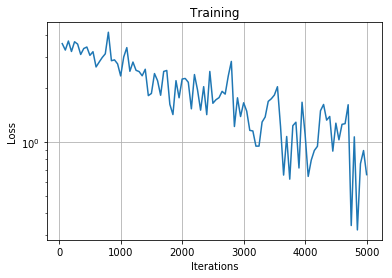

In [56]:
fig,ax=plt.subplots(figsize=(6,4))
ax.semilogy(train_data[:,0],train_data[:,1],label='loss')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Training')
ax.grid(True)

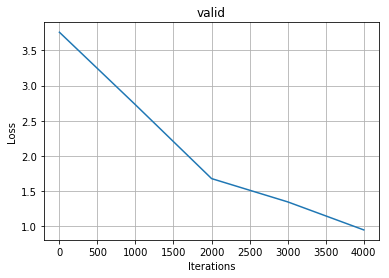

In [60]:
valid_data = np.loadtxt(LOG_DIR+'/validation.txt')
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(valid_data[:,0],valid_data[:,1],label='loss')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('valid')
ax.grid(True)

In [61]:
output = estimator.predict(input_fn(valid_set, mode=tf.estimator.ModeKeys.PREDICT))


# We need to loop over the returned 'output' generator to actually execute the network for the current sample.
for out in output:
    
    print ('Predicted class: {}'.format(out['prediction']))

INFO:tensorflow:Restoring parameters from ./cnn_output\model.ckpt-5000


KeyError: 'prediction'

<generator object Estimator.predict at 0x00000263F0CCAFC0>